<a href="https://colab.research.google.com/github/SunForLife/raiffeisen/blob/master/home_credit_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install kaggle
import json
import zipfile
import os
!mkdir /root/.kaggle
!echo '' > /root/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json
!kaggle config path -p /root
!kaggle competitions download -c home-credit-default-risk
for file in os.listdir():
    if not file.endswith('.zip'):
        continue
    zip_ref = zipfile.ZipFile(file, 'r')
    zip_ref.extractall()
    zip_ref.close()

mkdir: cannot create directory ‘/root/.kaggle’: File exists
usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: argument command: invalid choice: 'path' (choose from 'view', 'set', 'unset')
installments_payments.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
HomeCredit_columns_description.csv: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv: Skipping, found more recently modified local copy (use --force to force download)
application_train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
POS_CASH_balance.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
credit_card_balance.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
application_test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
previous_application.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from xgboost import XGBClassifier

In [ ]:
train = pd.read_csv('application_train.csv')

train_numeric = train.select_dtypes([np.number]).fillna(0)

X = train_numeric.drop(labels=['TARGET'], axis="columns")
y = train_numeric['TARGET']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# reg = LogisticRegression(max_iter=1000000).fit(X_train, y_train)
gb = XGBClassifier(tree_method='gpu_hist').fit(X_train, y_train)

In [ ]:
print(accuracy_score(y_test, gb.predict(X_test)))
print(precision_score(y_test, gb.predict(X_test)))
print(recall_score(y_test, gb.predict(X_test)))
print(roc_auc_score(y_test, gb.predict_proba(X_test)[:, 1]))

0.9195811586426679
0.56
0.002828854314002829
0.7436057604734183


## Functions part

In [ ]:
def aggregate_numeric_fields(df, columns_to_drop, group_by, agg_methods, name_prefix):
    cnt_numeric_fields_statistics = df.drop(columns = columns_to_drop).groupby(group_by, as_index = False).agg(agg_methods).reset_index()

    columns = [group_by]
    for column in cnt_numeric_fields_statistics.columns.levels[0]:
        if column == group_by:
            continue

        for stat in cnt_numeric_fields_statistics.columns.levels[1][:-1]:
            columns.append('{}_{}_{}'.format(name_prefix, column, stat))

    cnt_numeric_fields_statistics.columns = columns

    return cnt_numeric_fields_statistics

## bureau part.

In [ ]:
bureau = pd.read_csv('bureau.csv')
data = X

In [ ]:
# Считаем активные и закрытые кредиты.
cnt_active_loans = bureau[bureau.CREDIT_ACTIVE == 'Active'].groupby('SK_ID_CURR', as_index=False)['CREDIT_ACTIVE'].count()
cnt_closed_loans = bureau[bureau.CREDIT_ACTIVE == 'Closed'].groupby('SK_ID_CURR', as_index=False)['CREDIT_ACTIVE'].count()

In [ ]:
# Мерджим фичи

data = data.merge(cnt_active_loans, on = 'SK_ID_CURR', how = 'left').fillna(0)
data = data.merge(cnt_closed_loans, on = 'SK_ID_CURR', how = 'left').fillna(0)

In [ ]:
# Теперь посчитаем для всех числовых колонок статистику по ним, что так же будет
# являтся хорошими фичами для нашей модели.
cnt_numeric_fields_statistics = aggregate_numeric_fields(bureau, ['SK_ID_BUREAU'], 'SK_ID_CURR', ['min', 'max', 'mean', 'sum'], 'bureau')

In [ ]:
data = data.merge(cnt_numeric_fields_statistics, on = 'SK_ID_CURR', how = 'left').fillna(0)

In [ ]:
# Оставшиеся текстовые колонки ohe кодируем, считая nan отдельным классом.

def one_hot_encoder(df):
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    return pd.get_dummies(df, columns=categorical_columns, dummy_na=True)

In [ ]:
credit_type_ohe = one_hot_encoder(bureau)

credit_type_ohe = credit_type_ohe.groupby('SK_ID_CURR', as_index=False).count()

data = data.merge(credit_type_ohe, on = 'SK_ID_CURR', how = 'left').fillna(0)

## bureau_balance part

In [ ]:
bureau_balance = pd.read_csv('bureau_balance.csv')
bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [ ]:
# Считаем статистику для MONTHS_BALANCE по ['min', 'mean', 'sum'].

cnt_numeric_fields_statistics = aggregate_numeric_fields(bureau_balance, ['STATUS'], 'SK_ID_BUREAU', ['min', 'mean', 'sum'], 'balance')
cnt_numeric_fields_statistics

,SK_ID_BUREAU,balance_MONTHS_BALANCE_min,balance_MONTHS_BALANCE_mean,balance_MONTHS_BALANCE_sum
0,5001709,-96,-48.0,-4656
1,5001710,-82,-41.0,-3403
2,5001711,-3,-1.5,-6
3,5001712,-18,-9.0,-171
4,5001713,-21,-10.5,-231
...,...,...,...,...
817390,6842884,-47,-23.5,-1128
817391,6842885,-23,-11.5,-276
817392,6842886,-32,-16.0,-528
817393,6842887,-36,-18.0,-666


In [ ]:
# Добавляем ohe по статусу.

status_ohe = one_hot_encoder(bureau_balance)

# И статистику по этому кодированию.

status_ohe_statistics = aggregate_numeric_fields(status_ohe, [], 'SK_ID_BUREAU', ['min', 'max', 'mean', 'sum'], 'balance')
status_ohe_statistics

,SK_ID_BUREAU,balance_MONTHS_BALANCE_min,balance_MONTHS_BALANCE_max,balance_MONTHS_BALANCE_mean,balance_MONTHS_BALANCE_sum,balance_STATUS_0_min,balance_STATUS_0_max,balance_STATUS_0_mean,balance_STATUS_0_sum,balance_STATUS_1_min,balance_STATUS_1_max,balance_STATUS_1_mean,balance_STATUS_1_sum,balance_STATUS_2_min,balance_STATUS_2_max,balance_STATUS_2_mean,balance_STATUS_2_sum,balance_STATUS_3_min,balance_STATUS_3_max,balance_STATUS_3_mean,balance_STATUS_3_sum,balance_STATUS_4_min,balance_STATUS_4_max,balance_STATUS_4_mean,balance_STATUS_4_sum,balance_STATUS_5_min,balance_STATUS_5_max,balance_STATUS_5_mean,balance_STATUS_5_sum,balance_STATUS_C_min,balance_STATUS_C_max,balance_STATUS_C_mean,balance_STATUS_C_sum,balance_STATUS_X_min,balance_STATUS_X_max,balance_STATUS_X_mean,balance_STATUS_X_sum,balance_STATUS_nan_min,balance_STATUS_nan_max,balance_STATUS_nan_mean,balance_STATUS_nan_sum
0,5001709,-96,0,-48.0,-4656,0,0,0.000000,0,0,0,0.000000,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,1,0.886598,86,0,1,0.113402,11,0,0,0,0
1,5001710,-82,0,-41.0,-3403,0,1,0.060241,5,0,0,0.000000,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,1,0.578313,48,0,1,0.361446,30,0,0,0,0
2,5001711,-3,0,-1.5,-6,0,1,0.750000,3,0,0,0.000000,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.000000,0,0,1,0.250000,1,0,0,0,0
3,5001712,-18,0,-9.0,-171,0,1,0.526316,10,0,0,0.000000,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,1,0.473684,9,0,0,0.000000,0,0,0,0,0
4,5001713,-21,0,-10.5,-231,0,0,0.000000,0,0,0,0.000000,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.000000,0,1,1,1.000000,22,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
817390,6842884,-47,0,-23.5,-1128,0,1,0.187500,9,0,0,0.000000,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,1,0.416667,20,0,1,0.395833,19,0,0,0,0
817391,6842885,-23,0,-11.5,-276,0,1,0.500000,12,0,0,0.000000,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,1,0.5,12,0,0,0.000000,0,0,0,0.000000,0,0,0,0,0
817392,6842886,-32,0,-16.0,-528,0,1,0.242424,8,0,0,0.000000,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,1,0.757576,25,0,0,0.000000,0,0,0,0,0
817393,6842887,-36,0,-18.0,-666,0,1,0.162162,6,0,0,0.000000,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,1,0.837838,31,0,0,0.000000,0,0,0,0,0


In [ ]:
# Объединяем cnt_numeric_fields_statistics и status_ohe_statistics по SK_ID_BUREAU.

bureau_balance_features = cnt_numeric_fields_statistics.merge(status_ohe_statistics, on = 'SK_ID_BUREAU', how = 'left').fillna(0)

In [ ]:
# Mерджим с bureau для нахождения SK_ID_CURR.

bureau_X_bureau_balance_features = bureau[['SK_ID_CURR', 'SK_ID_BUREAU']].merge(bureau_balance_features, on = 'SK_ID_BUREAU', how = 'left').fillna(0)

# И опять статистику.

bureau_X_bureau_balance_features_features = aggregate_numeric_fields(bureau_X_bureau_balance_features, ['SK_ID_BUREAU'], 'SK_ID_CURR', ['min', 'max', 'mean', 'sum'], 'id')

In [ ]:
data = data.merge(bureau_X_bureau_balance_features_features, on = 'SK_ID_CURR', how = 'left').fillna(0)

In [ ]:
bureau_X_bureau_balance_features_features.head()

,SK_ID_CURR,id_balance_MONTHS_BALANCE_min_x_min,id_balance_MONTHS_BALANCE_min_x_max,id_balance_MONTHS_BALANCE_min_x_mean,id_balance_MONTHS_BALANCE_min_x_sum,id_balance_MONTHS_BALANCE_mean_x_min,id_balance_MONTHS_BALANCE_mean_x_max,id_balance_MONTHS_BALANCE_mean_x_mean,id_balance_MONTHS_BALANCE_mean_x_sum,id_balance_MONTHS_BALANCE_sum_x_min,id_balance_MONTHS_BALANCE_sum_x_max,id_balance_MONTHS_BALANCE_sum_x_mean,id_balance_MONTHS_BALANCE_sum_x_sum,id_balance_MONTHS_BALANCE_min_y_min,id_balance_MONTHS_BALANCE_min_y_max,id_balance_MONTHS_BALANCE_min_y_mean,id_balance_MONTHS_BALANCE_min_y_sum,id_balance_MONTHS_BALANCE_max_min,id_balance_MONTHS_BALANCE_max_max,id_balance_MONTHS_BALANCE_max_mean,id_balance_MONTHS_BALANCE_max_sum,id_balance_MONTHS_BALANCE_mean_y_min,id_balance_MONTHS_BALANCE_mean_y_max,id_balance_MONTHS_BALANCE_mean_y_mean,id_balance_MONTHS_BALANCE_mean_y_sum,id_balance_MONTHS_BALANCE_sum_y_min,id_balance_MONTHS_BALANCE_sum_y_max,id_balance_MONTHS_BALANCE_sum_y_mean,id_balance_MONTHS_BALANCE_sum_y_sum,id_balance_STATUS_0_min_min,id_balance_STATUS_0_min_max,id_balance_STATUS_0_min_mean,id_balance_STATUS_0_min_sum,id_balance_STATUS_0_max_min,id_balance_STATUS_0_max_max,id_balance_STATUS_0_max_mean,id_balance_STATUS_0_max_sum,id_balance_STATUS_0_mean_min,id_balance_STATUS_0_mean_max,id_balance_STATUS_0_mean_mean,...,id_balance_STATUS_C_mean_min,id_balance_STATUS_C_mean_max,id_balance_STATUS_C_mean_mean,id_balance_STATUS_C_mean_sum,id_balance_STATUS_C_sum_min,id_balance_STATUS_C_sum_max,id_balance_STATUS_C_sum_mean,id_balance_STATUS_C_sum_sum,id_balance_STATUS_X_min_min,id_balance_STATUS_X_min_max,id_balance_STATUS_X_min_mean,id_balance_STATUS_X_min_sum,id_balance_STATUS_X_max_min,id_balance_STATUS_X_max_max,id_balance_STATUS_X_max_mean,id_balance_STATUS_X_max_sum,id_balance_STATUS_X_mean_min,id_balance_STATUS_X_mean_max,id_balance_STATUS_X_mean_mean,id_balance_STATUS_X_mean_sum,id_balance_STATUS_X_sum_min,id_balance_STATUS_X_sum_max,id_balance_STATUS_X_sum_mean,id_balance_STATUS_X_sum_sum,id_balance_STATUS_nan_min_min,id_balance_STATUS_nan_min_max,id_balance_STATUS_nan_min_mean,id_balance_STATUS_nan_min_sum,id_balance_STATUS_nan_max_min,id_balance_STATUS_nan_max_max,id_balance_STATUS_nan_max_mean,id_balance_STATUS_nan_max_sum,id_balance_STATUS_nan_mean_min,id_balance_STATUS_nan_mean_max,id_balance_STATUS_nan_mean_mean,id_balance_STATUS_nan_mean_sum,id_balance_STATUS_nan_sum_min,id_balance_STATUS_nan_sum_max,id_balance_STATUS_nan_sum_mean,id_balance_STATUS_nan_sum_sum
0,100001,-51.0,-1.0,-23.571429,-165.0,-25.5,-0.5,-11.785714,-82.5,-1326.0,-1.0,-400.000000,-2800.0,-51.0,-1.0,-23.571429,-165.0,0.0,0.0,0.0,0.0,-25.5,-0.5,-11.785714,-82.5,-1326.0,-1.0,-400.000000,-2800.0,0.0,1.0,0.142857,1.0,1.0,1.0,1.0,7.0,0.019231,1.000000,0.336651,...,0.0,0.966667,0.441240,3.088683,0.0,44.0,15.714286,110.0,0.0,0.0,0.0,0.0,0.0,1.0,0.714286,5.0,0.0,0.500000,0.214590,1.502129,0.0,9.0,4.285714,30.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,100002,-47.0,-3.0,-28.250000,-226.0,-39.5,-1.5,-21.875000,-175.0,-632.0,-6.0,-337.625000,-2701.0,-47.0,-3.0,-28.250000,-226.0,-32.0,0.0,-15.5,-124.0,-39.5,-1.5,-21.875000,-175.0,-632.0,-6.0,-337.625000,-2701.0,0.0,0.0,0.000000,0.0,1.0,1.0,1.0,8.0,0.187500,0.818182,0.406960,...,0.0,0.812500,0.175426,1.403409,0.0,13.0,2.875000,23.0,0.0,0.0,0.0,0.0,0.0,1.0,0.750000,6.0,0.0,0.500000,0.161932,1.295455,0.0,3.0,1.875000,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100003,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100004,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0000

## Score part.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size=0.2, random_state=42)

In [ ]:
gb_new = XGBClassifier(tree_method='gpu_hist', max_depth=7, learning_rate=0.05, n_estimators=250).fit(X_train, y_train)

In [ ]:
print(accuracy_score(y_test, gb_new.predict(X_test)))
print(precision_score(y_test, gb_new.predict(X_test)))
print(recall_score(y_test, gb_new.predict(X_test)))
print(roc_auc_score(y_test, gb_new.predict_proba(X_test)[:, 1]))

0.9199063460319009
0.5628415300546448
0.02081228531016367
0.7607737069253966


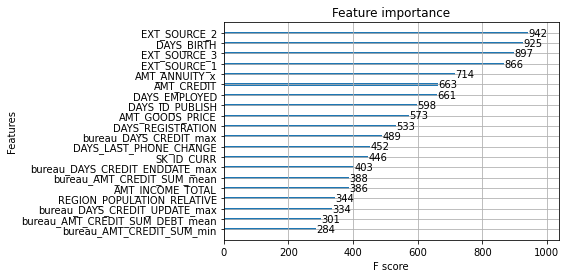

In [ ]:
from xgboost import plot_importance

plot_importance(gb_new, max_num_features=20)